<a href="https://colab.research.google.com/github/Jorayala/AI_Master_UniAndes_2024/blob/main/Connect4_RL_MAIA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import gym
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [6]:
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        self.rows = 6
        self.columns = 7
        self.action_space = gym.spaces.Discrete(self.columns)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.rows, self.columns), dtype=np.float64)
        self.q_table = {}  # Dictionary-based Q-table
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.columns), dtype=np.float64)
        self.current_player = 1
        return self._get_observation()

    def _get_observation(self):
        # Convert the board to a tuple to use it as a key in the dictionary
        return tuple(map(tuple, self.board))

    def change_reward(self, old_reward, done):
        if old_reward == 1:  # The agent won the game
            return 1
        elif done:  # The opponent won the game
            return -1
        else:  # Reward 1/42
            return 1 / (self.rows * self.columns)

    def step(self, action):
        if self.board[0, action] != 0:  # Invalid move
            reward, done = -10, True
        else:
            # Place the piece in the lowest available row
            for row in range(self.rows - 1, -1, -1):
                if self.board[row, action] == 0:
                    self.board[row, action] = self.current_player
                    break
            # Check for win or draw
            done = self._check_done()
            reward = 1 if done and self._check_winner() else 0
            reward = self.change_reward(reward, done)
            self.current_player = 3 - self.current_player  # Switch player

        # Visualize the board only if there's a win
            if done and reward == 1:
                self.print_board()


        # Get the current state as a tuple
        state = self._get_observation()

        # Check if the state is in the Q-table, if not, initialize it
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.columns)

        return self._get_observation(), reward, done, {}

    def _check_done(self):
        return np.all(self.board != 0) or self._check_winner()

    def _check_winner(self):
        # Check for four in a row (horizontal, vertical, diagonal)
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row, col + 1] == self.board[row, col + 2] == self.board[row, col + 3]:
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns):
                if self.board[row, col] == self.current_player == self.board[row + 1, col] == self.board[row + 2, col] == self.board[row + 3, col]:
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row + 1, col + 1] == self.board[row + 2, col + 2] == self.board[row + 3, col + 3]:
                    return True
        for row in range(3, self.rows):
            for col in range(self.columns - 3):
                if self.board[row, col] == self.current_player == self.board[row - 1, col + 1] == self.board[row - 2, col + 2] == self.board[row - 3, col + 3]:
                    return
    """
    def visualize_board(self):
        plt.imshow(self.board, cmap='cool', aspect='auto')
        plt.title(f'Current Player: {self.current_player}')
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(range(self.columns))
        plt.yticks(range(self.rows))
        plt.show() """
    def print_board(self):
        board_str = "\n".join([" ".join([str(int(cell)) for cell in row]) for row in self.board])
        print(f"Current Board:\n{board_str}\n")


In [7]:
# Create ConnectFour environment
env = ConnectFourGym()

# Q-Learning parameters
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 10000



In [8]:
# List to store rewards for each episode
rewards = []
# Q-Learning algorithm
for episode in range(episodes):
    state = env.reset()
    # Flatten the state tuple and then convert to index
    state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))
    done = False
    total_reward = 0
    while not done:
        # Exploration-exploitation trade-off
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore: select a random action
        else:
            # If state_index is not in the q_table, initialize it
            if state_index not in env.q_table:
                env.q_table[state_index] = np.zeros(env.columns)
            action = np.argmax(env.q_table[state_index])  # Exploit: select the action with max value (greedy)

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        # Flatten the next_state tuple and then convert to index
        next_state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(next_state).flatten())]))

        # Q-learning update
        # If next_state_index is not in the q_table, initialize it
        if next_state_index not in env.q_table:
            env.q_table[next_state_index] = np.zeros(env.columns)

        best_next_action = np.argmax(env.q_table[next_state_index])
        # Access the Q-value using next_state_index and best_next_action as indices
        td_target = reward + gamma * env.q_table[next_state_index][best_next_action] * (not done)
        # Make sure state_index is in the q_table before accessing it
        if state_index not in env.q_table:
            env.q_table[state_index] = np.zeros(env.columns)

        td_error = td_target - env.q_table[state_index][action] # Access the Q-value using state_index and action as indices
        env.q_table[state_index][action] += alpha * td_error # Access the Q-value using state_index and action as indices

        state_index = next_state_index

    # Store the total reward for the episode
    rewards.append(total_reward)

    # Decrease epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Visualize the board every 1000 episodes
    if episode % 1000 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")
        env.print_board()

# Save the Q-table
np.save("connect4_q_table.npy", env.q_table)

Streaming output truncated to the last 5000 lines.
Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 

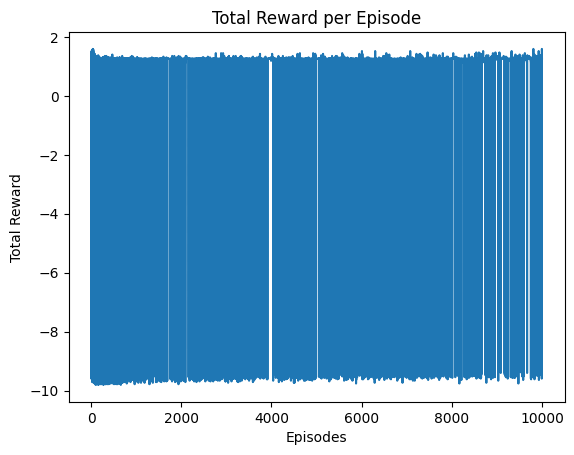

In [9]:
# Plot the rewards over episodes
plt.plot(range(episodes), rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [10]:
# Test the trained agent
def test_agent(env, q_table, episodes=10):
    for episode in range(episodes):
        state = env.reset()
        # Flatten the state tuple and then convert to index
        state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))
        done = False
        while not done:
            # Accessing q_table with the integer index directly
            # If state_index is not in q_table, default to zeros
            action = np.argmax(q_table.get(state_index, np.zeros(env.columns)) if isinstance(q_table, dict) else \
                                (q_table[state_index] if state_index in q_table else np.zeros(env.columns)))
            state, reward, done, _ = env.step(action)
            # Flatten the state tuple and then convert to index
            state_index = int(sum([val * (3 ** i) for i, val in enumerate(np.array(state).flatten())]))

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1

Current Board:
0 0 0 0 0 0 0
1 0 0 0 0 0 0
1 2 0 0 0 0 0
1 2 0 0 0 0 0
2 2 0 0 1 0 0
2 2 0 0 1 0 1



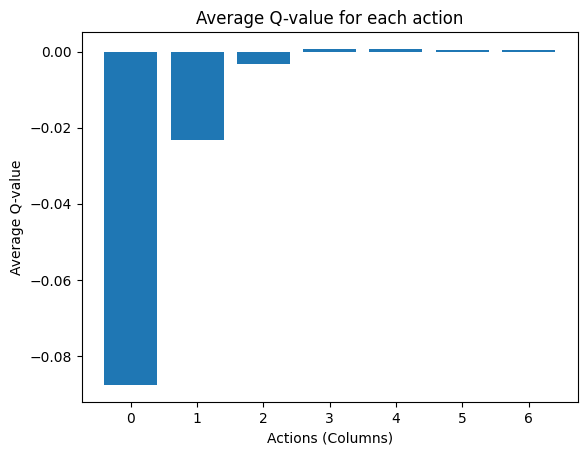

In [11]:
# Load and test the trained Q-table
q_table = np.load("connect4_q_table.npy", allow_pickle=True).item() # Load as dictionary using .item()
test_agent(env, q_table, episodes=5)

# Visualize the Q-table using matplotlib
def visualize_q_table(q_table, columns=7):
    # Check if the Q-table is a dictionary and convert it to a numpy array if needed
    if isinstance(q_table, dict):
        q_table_array = np.array(list(q_table.values()))
    else:
        q_table_array = q_table

    # If q_table_array is not empty, calculate the average Q-values
    if q_table_array.size > 0:
        avg_q_values = np.mean(q_table_array, axis=0)
        plt.bar(range(columns), avg_q_values)
        plt.xlabel('Actions (Columns)')
        plt.ylabel('Average Q-value')
        plt.title('Average Q-value for each action')
        plt.show()
    else:
        print("Q-table is empty. Cannot visualize.")

# Call the visualization function
visualize_q_table(q_table, env.columns)  # Pass env.columns for flexibility